## Libraries and Dependancies Needed to Run the Following Code
* The kernel for the following notebook is Python 3.10.7
* For the code to work in your local enviroment, there are some libraries that you might have to install. Most of them are quite straightforward, and can be ascertained from the below import. 
* The second half of the notebook includes an implementation using the pystata library to run stata code from within python. This not only requires you to possess a stata license and the necessary files for stata, but also the installation and configuration of pystata.

## Implementation using PyStata 
### (Running Stata Code From Within Python)
- Some of code will need to be edited to your working directory. 
- You require a Stata license to run this code. 
- Please refer to the pystata documentation for the configuration of pystata. 
- Stata code is prefixed with the command `%%stata`

In [1]:
import pandas as pd
import statsmodels.api as sm
import linearmodels as lm
import pyreadstat
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from scipy.stats import pearsonr
from linearmodels.panel import compare


In [2]:
import sys
sys.path.append('/Applications/Stata/utilities')
from pystata import config
config.init('se')


  ___  ____  ____  ____  ____ ©
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       SE—Standard Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Unlimited-user network, expiring 21 Sep 2023
Serial number: 401709301720
  Licensed to: Dhruv Akshay Pandit
               ISEG

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. Maximum number of variables is set to 5,000; see help set_maxvar.


# Model selection for the analysis and prediction of crime rate in

### Data Import 
Our data is stored locally, and the file path has been given as such. The data is stored in .dta format for stata files, and the associated variable labels are derived using the pyreadstat library and stored in a dictionary.
**The data is assumed to be log transformed according the equation stated.**

$log(crmrte_{it})=\alpha+ \beta_1 log(prbconv_{it})+ \beta_2 log(prbarr_{it})+ \beta_3 log(avgsen_{it})+ \beta_4log(polpc_{it})+ \beta_5 log(density_{it}) + \beta_6 taxp_{it} + \beta_7 West_{it} + \beta_8 central_{it} + \beta_9 urban_{it}+ v_{it}$

In [3]:
data_stata, meta = pyreadstat.read_dta(r'/Users/dhruvpandit/Documents/GitHub/ISEG_AEF/Semester-Two-Projects/T1.dta')
label_dict = {}
for var_name, label in zip(meta.column_names, meta.column_labels):
    label_dict[var_name] = label


##### Stata code

In [4]:
%%stata
use /Users/dhruvpandit/Documents/GitHub/ISEG_AEF/Semester-Two-Projects/T1.dta
describe


. use /Users/dhruvpandit/Documents/GitHub/ISEG_AEF/Semester-Two-Projects/T1.dta

. describe

Contains data from /Users/dhruvpandit/Documents/GitHub/ISEG_AEF/Semester-Two-Pr
> ojects/T1.dta
 Observations:           630                  
    Variables:            54                  20 Feb 2023 18:59
-------------------------------------------------------------------------------
Variable      Storage   Display    Value
    name         type    format    label      Variable label
-------------------------------------------------------------------------------
county          int     %9.0g                 county identifier
year            byte    %ty                   81 to 87
crmrte          float   %9.0g                 crimes committed per person
prbarr          float   %9.0g                 'probability' of arrest
prbconv         float   %9.0g                 'probability' of conviction
prbpris         float   %9.0g                 'probability' of prison sentenc
avgsen          float 

#### Is our Data Unbalanced?
In Balanced data every unit is observed in every time period, and the number of time periods is equal for all observations. Our data is balanced, as evident from the output of the code below. 

In [5]:
obs_counts = data_stata.groupby('county')['year'].count()
if obs_counts.std() > 0: print('Unbalanced Data') 
else: print('Balanced')

Balanced


In [6]:
%%stata
. xtset county year, yearly



Panel variable: county (strongly balanced)
 Time variable: year, 81 to 87
         Delta: 1 year


#### Format Data Years
- The stata data has the years formatted as suffixes (eg. 1981 is formatted as 81). This needs to be corrected for our regression to be carried out.

In [6]:
data_stata['year'] = data_stata['year'].apply(lambda x: '19'+str(x))
data_stata['year'] = pd.to_datetime(data_stata['year'], format='%Y')
data_stata = data_stata[['county', 'year','crmrte', 'prbconv', 'prbarr', 'avgsen', 'polpc', 'density', 'taxpc', 'west', 'central', 'urban' ]]

data_stata.columns = data_stata.columns.astype(str)



In [8]:
data_stata.describe()

,county,crmrte,prbconv,prbarr,avgsen,polpc,density,taxpc,west,central,urban
count,630.00000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000
mean,100.60000,0.031588,0.688618,0.307368,8.954540,0.001917,1.386062,30.239194,0.233333,0.377778,0.088889
std,58.03627,0.018121,1.690345,0.171205,2.658082,0.002735,1.439703,11.454694,0.423289,0.485217,0.284809
min,1.00000,0.001812,0.068376,0.058823,4.220000,0.000459,0.197719,14.302565,0.000000,0.000000,0.000000
25%,51.00000,0.018352,0.347692,0.217902,7.160000,0.001191,0.532944,23.425596,0.000000,0.000000,0.000000
50%,103.00000,0.028441,0.474375,0.278240,8.495000,0.001451,0.952595,27.792328,0.000000,0.000000,0.000000
75%,151.00000,0.038406,0.635597,0.352518,10.197500,0.001803,1.507818,33.271218,0.000000,1.000000,0.000000
max,197.00000,0.163835,37.000000,2.750000,25.830000,0.035578,8.827652,119.761452,1.000000,1.000000,1.000000


In [9]:
%%stata
. xtdescribe


  county:  1, 3, ..., 197                                    n =         90
    year:  81, 82, ..., 87                                   T =          7
           Delta(year) = 1 year
           Span(year)  = 7 periods
           (county*year uniquely identifies each observation)

Distribution of T_i:   min      5%     25%       50%       75%     95%     max
                         7       7       7         7         7       7       7

     Freq.  Percent    Cum. |  Pattern
 ---------------------------+---------
       90    100.00  100.00 |  1111111
 ---------------------------+---------
       90    100.00         |  XXXXXXX


#### Multindexing
- When working with panel data in python, we need to create a multindex for our dataframe, essentially defining the variables that will form our sub i and sub t.
- In the above data, the county is indexed as sub i, and the year indexed as sub t. 

In [10]:
#Creating MultiIndex Dataframe on County and Year
data_df_multi = data_stata.set_index(['county', 'year'])

### Simple Scatter PLots 

In [11]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots()

fig.add_trace(go.Scatter(x=data_stata['crmrte'], y=data_stata['prbconv'],
                    mode='markers', name='crmrte', ))
fig.update_layout(title={'text':'crmrte vs Variables', "x" : 0.5},
                   xaxis_title='Var',
                   yaxis_title='crmrte', font=dict(family='Futura', color='#000000' , size=14))
fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=[{'x': [data_stata['prbarr']]}],
                    label="prbarr",
                    method='restyle'
                ),
                dict(
                    args=[{'x': [data_stata['avgsen']]}],
                    label="avgsen",
                    method='restyle'
                ),
                dict(
                    args=[{'x': [data_stata['polpc']]}],
                    label="polpc",
                    method='restyle'
                ),
                dict(
                    args=[{'x': [data_stata['density']]}],
                    label="density",
                    method='restyle'
                ),
            ]),
            direction="down",
            showactive=True,
            x=0.1,
            xanchor="left",
            y=1.2,
            yanchor="top"
        ),
    ]
)
fig.show()

#### Time fixed effect
- Economic effects that are specific to a given year due to macroeconomic shocks or policies that impact all the units in average with the same amoutn of effect in that year. 
- Effects that are specific to the time period
- Because panel data has time dimension, and things vary in time. Need to take into accountht the time variation
- To control for time fixed effects, we can introduce a dummy variable that is specific to given year. These are dummy variables equal to 1 for each year. 

In [12]:
#creating dummy variables for the time periods
data_stata['year'] = data_stata['year'].dt.year
dummies = pd.get_dummies(data_stata['year'], )
data_stata = pd.concat([data_stata, dummies], axis = 1)

data_df_multi_dummy = data_stata.set_index(['county', 'year'])

In [13]:
data_df_multi_dummy.columns = data_df_multi_dummy.columns.astype(str)


In [14]:
%%stata
. tab year, gen(y)


   81 to 87 |      Freq.     Percent        Cum.
------------+-----------------------------------
         81 |         90       14.29       14.29
         82 |         90       14.29       28.57
         83 |         90       14.29       42.86
         84 |         90       14.29       57.14
         85 |         90       14.29       71.43
         86 |         90       14.29       85.71
         87 |         90       14.29      100.00
------------+-----------------------------------
      Total |        630      100.00


In [15]:
%%stata
. global yxvars crmrte prbconv prbarr avgsen polpc density taxpc west central urban
. xtsum $yxvars


. . global yxvars crmrte prbconv prbarr avgsen polpc density taxpc west central
>  urban

. . xtsum $yxvars

Variable         |      Mean   Std. dev.       Min        Max |    Observations
-----------------+--------------------------------------------+----------------
crmrte   overall |  .0315876   .0181209   .0018116    .163835 |     N =     630
         between |             .0169893   .0039699   .0886855 |     n =      90
         within  |             .0065179  -.0112836   .1258057 |     T =       7
                 |                                            |
prbconv  overall |  .6886176   1.690345   .0683761         37 |     N =     630
         between |             .9267132   .2391829   8.315754 |     n =      90
         within  |             1.416566  -5.505927   29.37286 |     T =       7
                 |                                            |
prbarr   overall |  .3073682   .1712047   .0588235       2.75 |     N =     630
         between |               .13578   

### Pooled OLS
- Starting Point for our regression analysis

In [16]:
exog = sm.add_constant(data_df_multi[['prbconv', 'prbarr', 'avgsen', 'polpc', 'density', 'taxpc', 'west', 'central', 'urban' ]] )
exog_fe = sm.add_constant(data_df_multi_dummy[[ 'prbconv',  'prbarr',  'avgsen',   'polpc', 'density',
         'taxpc',    'west', 'central',   'urban',      '1981',      '1982',
            '1983',      '1984',      '1985',      '1986']])
pooled_model  = lm.PooledOLS(data_df_multi_dummy['crmrte'], exog_fe)
pooled_result = pooled_model.fit() #using non robust errors

In [17]:
%%stata
. reg $yxvars y1-y6, vce(cluster county)


Linear regression                               Number of obs     =        630
                                                F(15, 89)         =      47.54
                                                Prob > F          =     0.0000
                                                R-squared         =     0.7131
                                                Root MSE          =     .00982

                                (Std. err. adjusted for 90 clusters in county)
------------------------------------------------------------------------------
             |               Robust
      crmrte | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
     prbconv |  -.0020738   .0007681    -2.70   0.008    -.0035999   -.0005476
      prbarr |  -.0293668   .0047169    -6.23   0.000    -.0387392   -.0199944
      avgsen |  -.0001851   .0001792    -1.03   0.304    -.0005411    .0001709
       polpc |

In [18]:
pooled_result

Dep. Variable:,crmrte,R-squared:,0.7131
Estimator:,PooledOLS,R-squared (Between):,0.7948
No. Observations:,630,R-squared (Within):,0.1633
Date:,"Thu, Mar 16 2023",R-squared (Overall):,0.7131
Time:,20:22:30,Log-likelihood,2026.6
Cov. Estimator:,Unadjusted,,
,,F-statistic:,101.75
Entities:,90,P-value,0.0000
Avg Obs:,7.0000,Distribution:,"F(15,614)"
Min Obs:,7.0000,,
Max Obs:,7.0000,F-statistic (robust):,101.75


In [19]:
het_white(pooled_result.resids, exog = exog)
#heteroskedasticity
#inefficient ols estimator
#need to use robust

(364.08355788117535,
 2.835619511718796e-49,
 15.85493385316901,
 3.89912744285136e-79)

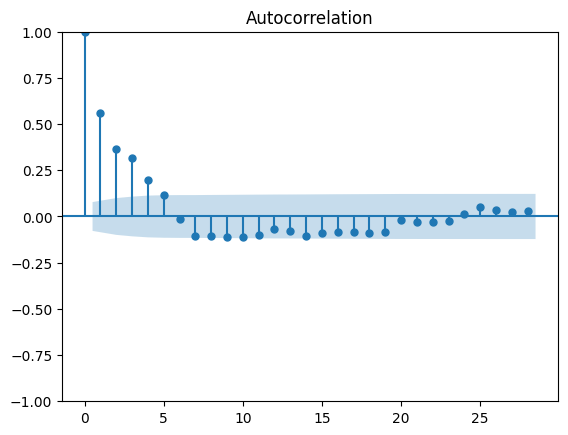

In [20]:
acf = sm.graphics.tsa.plot_acf(pooled_result.resids)
#autocorrelation between residuals
#violation of gaus markov, stat inference inccorrect

#### Pooled OLS Results
- Our model suffers from heteroskedasticity. We should use robust standard errors for inference. 
- There is correlation between dependent variable and residuals. It is possible that we have incorrectly specified our model.

In [21]:
pooled_result_robust = pooled_model.fit(cov_type="clustered", cluster_entity = True)
pooled_result_robust

Dep. Variable:,crmrte,R-squared:,0.7131
Estimator:,PooledOLS,R-squared (Between):,0.7948
No. Observations:,630,R-squared (Within):,0.1633
Date:,"Thu, Mar 16 2023",R-squared (Overall):,0.7131
Time:,20:22:31,Log-likelihood,2026.6
Cov. Estimator:,Clustered,,
,,F-statistic:,101.75
Entities:,90,P-value,0.0000
Avg Obs:,7.0000,Distribution:,"F(15,614)"
Min Obs:,7.0000,,
Max Obs:,7.0000,F-statistic (robust):,48.002


In [22]:
print(compare({"Robust": pooled_result_robust, "Pooled": pooled_result}))

               Model Comparison               
                           Robust       Pooled
----------------------------------------------
Dep. Variable              crmrte       crmrte
Estimator               PooledOLS    PooledOLS
No. Observations              630          630
Cov. Est.               Clustered   Unadjusted
R-squared                  0.7131       0.7131
R-Squared (Within)         0.1633       0.1633
R-Squared (Between)        0.7948       0.7948
R-Squared (Overall)        0.7131       0.7131
F-statistic                101.75       101.75
P-value (F-stat)           0.0000       0.0000
===================== =========== ============
const                      0.0334       0.0334
                         (5.3576)     (12.698)
prbconv                   -0.0021      -0.0021
                        (-2.7128)    (-7.7803)
prbarr                    -0.0294      -0.0294
                        (-6.2558)    (-11.597)
avgsen                    -0.0002      -0.0002
             

In [23]:
%%stata
. estimates store beta_POLS
. test (y1 y2 y3 y4 y5 y6)


. . estimates store beta_POLS

. . test (y1 y2 y3 y4 y5 y6)

 ( 1)  y1 = 0
 ( 2)  y2 = 0
 ( 3)  y3 = 0
 ( 4)  y4 = 0
 ( 5)  y5 = 0
 ( 6)  y6 = 0

       F(  6,    89) =   12.95
            Prob > F =    0.0000

. 


### Fixed Effect Model

#### Fixed Effects Model Fitting
- We have included the dummy variables for each year, and set the `entitiy_effects` to true, which controls for time invariant heterogeneity. 
- To control for heteroskedasticity, robust SE are obtained using the clustered covariance type.
- `drop_absorbed` is set to true to remove variables that have been fully absorbed from the regression. This drops variables that are constant in time. 

In [24]:
fe_results_clustered = lm.PanelOLS(data_df_multi_dummy['crmrte'], exog=exog_fe, entity_effects=True, drop_absorbed=True).fit(cov_type='clustered', cluster_entity = True)
fe_results_clustered

/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_16462/1670252039.py:1: AbsorbingEffectWarning:


Variables have been fully absorbed and have removed from the regression:

west, central, urban




Dep. Variable:,crmrte,R-squared:,0.3075
Estimator:,PanelOLS,R-squared (Between):,0.3588
No. Observations:,630,R-squared (Within):,0.3075
Date:,"Thu, Mar 16 2023",R-squared (Overall):,0.3522
Time:,20:22:31,Log-likelihood,2393.2
Cov. Estimator:,Clustered,,
,,F-statistic:,19.537
Entities:,90,P-value,0.0000
Avg Obs:,7.0000,Distribution:,"F(12,528)"
Min Obs:,7.0000,,
Max Obs:,7.0000,F-statistic (robust):,44.295


In [25]:
%%stata
. xtreg $yxvars y1-y6, fe
. estimates store beta_FE



. . xtreg $yxvars y1-y6, fe
note: west omitted because of collinearity.
note: central omitted because of collinearity.
note: urban omitted because of collinearity.

Fixed-effects (within) regression               Number of obs     =        630
Group variable: county                          Number of groups  =         90

R-squared:                                      Obs per group:
     Within  = 0.3075                                         min =          7
     Between = 0.5080                                         avg =        7.0
     Overall = 0.4431                                         max =          7

                                                F(12,528)         =      19.54
corr(u_i, Xb) = 0.4035                          Prob > F          =     0.0000

------------------------------------------------------------------------------
      crmrte | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+-------------------------------------------

#### FE Model Diagnostics

(595.7578682088997, 8.997639813500446e-68, 82.08875425660734, 6.484364562386284e-269)
PearsonRResult(statistic=0.2993245250714018, pvalue=1.6578725356153848e-14)


Pooled F-statistic
H0: Effects are zero
Statistic: 18.0961
P-value: 0.0000
Distributed: F(89,528)


Model F-statistic (homoskedastic)
H0: All parameters ex. constant are zero
Statistic: 19.5367
P-value: 0.0000
Distributed: F(12,528)


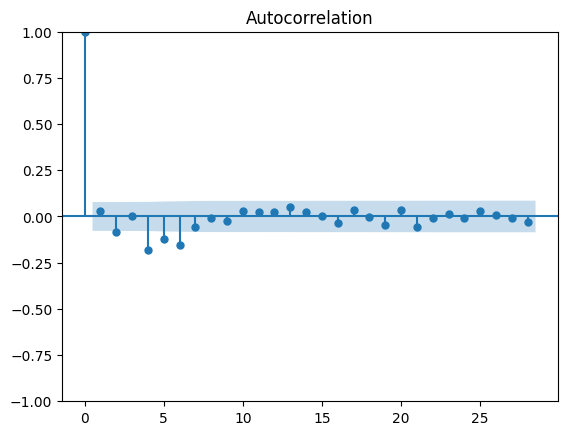

In [26]:
print(het_white(fe_results_clustered.resids, exog = exog_fe))
print(pearsonr(data_df_multi_dummy['crmrte'], fe_results_clustered.resids))
print('\n')

print(fe_results_clustered.f_pooled)
print('\n')
print(fe_results_clustered.f_statistic)
acf_fe = sm.graphics.tsa.plot_acf(fe_results_clustered.resids)



In [27]:
%%stata
. xttest3


Modified Wald test for groupwise heteroskedasticity
in fixed effect regression model

H0: sigma(i)^2 = sigma^2 for all i

chi2 (90)  =   40453.85
Prob>chi2 =      0.0000



In [28]:
%%stata
. xtserial $yxvars y1-y6


Wooldridge test for autocorrelation in panel data
H0: no first order autocorrelation
    F(  1,      89) =      0.381
           Prob > F =      0.5387


In [29]:
%%stata
. xtreg $yxvars y1-y6, fe vce(cluster county)

note: west omitted because of collinearity.
note: central omitted because of collinearity.
note: urban omitted because of collinearity.

Fixed-effects (within) regression               Number of obs     =        630
Group variable: county                          Number of groups  =         90

R-squared:                                      Obs per group:
     Within  = 0.3075                                         min =          7
     Between = 0.5080                                         avg =        7.0
     Overall = 0.4431                                         max =          7

                                                F(12,89)          =      43.87
corr(u_i, Xb) = 0.4035                          Prob > F          =     0.0000

                                (Std. err. adjusted for 90 clusters in county)
------------------------------------------------------------------------------
             |               Robust
      crmrte | Coefficient  std. err.      t    P>

### Random Effects Model

In [30]:
re_model = lm.RandomEffects(data_df_multi_dummy['crmrte'], exog_fe)
re_results = re_model.fit(cov_type='clustered', cluster_entity = True)

In [31]:
%%stata
. xtreg $yxvars y1-y6, re
. estimates store beta_RE


. . xtreg $yxvars y1-y6, re

Random-effects GLS regression                   Number of obs     =        630
Group variable: county                          Number of groups  =         90

R-squared:                                      Obs per group:
     Within  = 0.3007                                         min =          7
     Between = 0.7422                                         avg =        7.0
     Overall = 0.6849                                         max =          7

                                                Wald chi2(15)     =     523.77
corr(u_i, X) = 0 (assumed)                      Prob > chi2       =     0.0000

------------------------------------------------------------------------------
      crmrte | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
     prbconv |  -.0011274   .0001894    -5.95   0.000    -.0014987   -.0007561
      prbarr |  -.0113875   .002278

In [32]:
re_results

Dep. Variable:,crmrte,R-squared:,0.4531
Estimator:,RandomEffects,R-squared (Between):,0.7403
No. Observations:,630,R-squared (Within):,0.3007
Date:,"Thu, Mar 16 2023",R-squared (Overall):,0.6834
Time:,20:22:32,Log-likelihood,2333.5
Cov. Estimator:,Clustered,,
,,F-statistic:,33.908
Entities:,90,P-value,0.0000
Avg Obs:,7.0000,Distribution:,"F(15,614)"
Min Obs:,7.0000,,
Max Obs:,7.0000,F-statistic (robust):,67.393


#### RE Model Diagnostics

(436.96603142142015, 3.293170535058554e-63, 26.21334825740892, 1.619160857772303e-117)
PearsonRResult(statistic=0.4810353510979873, pvalue=8.494831762945844e-38)


Model F-statistic (homoskedastic)
H0: All parameters ex. constant are zero
Statistic: 33.9077
P-value: 0.0000
Distributed: F(15,614)


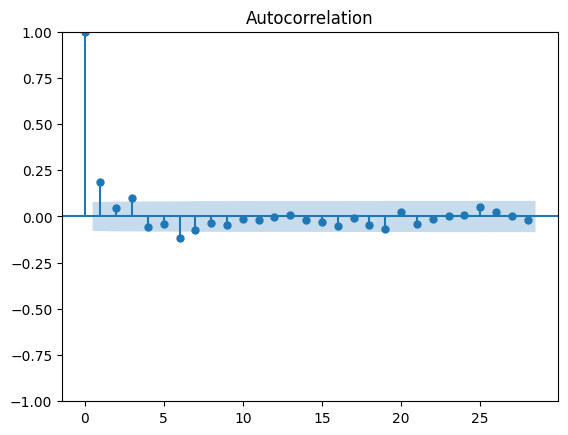

In [33]:
print(het_white(re_results.resids, exog = exog))
print(pearsonr(data_df_multi['crmrte'], re_results.resids))
print('\n')
print(re_results.f_statistic)

acf_re = sm.graphics.tsa.plot_acf(re_results.resids)



In [34]:
%%stata
. xttest0



Breusch and Pagan Lagrangian multiplier test for random effects

        crmrte[county,t] = Xb + u[county] + e[county,t]

        Estimated results:
                         |       Var     SD = sqrt(Var)
                ---------+-----------------------------
                  crmrte |   .0003284       .0181209
                       e |    .000035       .0059201
                       u |   .0000541       .0073528

        Test: Var(u) = 0
                             chibar2(01) =   592.27
                          Prob > chibar2 =   0.0000


In [35]:
%%stata
. xtreg $yxvars y1-y6, re vce(cluster county)


Random-effects GLS regression                   Number of obs     =        630
Group variable: county                          Number of groups  =         90

R-squared:                                      Obs per group:
     Within  = 0.3007                                         min =          7
     Between = 0.7422                                         avg =        7.0
     Overall = 0.6849                                         max =          7

                                                Wald chi2(15)     =     985.32
corr(u_i, X) = 0 (assumed)                      Prob > chi2       =     0.0000

                                (Std. err. adjusted for 90 clusters in county)
------------------------------------------------------------------------------
             |               Robust
      crmrte | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
     prbconv |  -.0011274   

In [36]:
from linearmodels.panel import compare

print(compare({"FE": fe_results_clustered, "RE": re_results, "Pooled": pooled_result_robust}))



                           Model Comparison                          
                                   FE                RE        Pooled
---------------------------------------------------------------------
Dep. Variable                  crmrte            crmrte        crmrte
Estimator                    PanelOLS     RandomEffects     PooledOLS
No. Observations                  630               630           630
Cov. Est.                   Clustered         Clustered     Clustered
R-squared                      0.3075            0.4531        0.7131
R-Squared (Within)             0.3075            0.3007        0.1633
R-Squared (Between)            0.3588            0.7403        0.7948
R-Squared (Overall)            0.3522            0.6834        0.7131
F-statistic                    19.537            33.908        101.75
P-value (F-stat)               0.0000            0.0000        0.0000
=====================     ===========   ===============   ===========
const               

In [37]:
%%stata
. estimates table beta_POLS beta_RE beta_FE, star(0.01 0.05 0.1)


--------------------------------------------------------------
    Variable |   beta_POLS        beta_RE         beta_FE     
-------------+------------------------------------------------
     prbconv | -.00207375***   -.00112743***   -.00095477***  
      prbarr | -.02936678***   -.01138751***   -.00705592***  
      avgsen |  -.0001851       .00004853       .00008775     
       polpc |  2.6118221***    2.1639995***    2.1206051***  
     density |  .00816042***    .00883316***    .00244864     
       taxpc |  .00003842       .00002959       .00004375     
        west |  -.0130544***   -.01359322***    (omitted)     
     central | -.00705607***   -.00752424***    (omitted)     
       urban | -.00230481      -.00282236       (omitted)     
          y1 |  .00123103       .00071608       .00019593     
          y2 |  .00058333        .0005353       .00014625     
          y3 | -.00129636      -.00168561      -.00208813**   
          y4 | -.00391078**    -.00391906***   -.00417

Testing for random effects: Breusch-Pagan Lagrange multiplier (LM)

In [38]:
#LM Test
import numpy as np
from scipy import stats

n = data_df_multi.index.levels[0].size
T = data_df_multi.index.levels[1].size
D = np.kron(np.eye(n), np.ones(T)).T
e = pooled_result.resids
LM = (e.dot(D).dot(D.T).dot(e) / e.dot(e) - 1) ** 2 * n * T / 2 / (T - 1)
LM_pvalue = stats.chi2(1).sf(LM)
print("LM Test: chisq = {0}, df = 1, p-value = {1}".format(LM, LM_pvalue))
def rejectRE(alpha, pvalue):
    if pvalue < alpha:
        return f'Random Effects are significant at a level of {alpha}'
    else:
        return f'Random Effects are insignificant at a level of {alpha}'
rejectRE(0.05, LM_pvalue)

LM Test: chisq = 592.2657107270627, df = 1, p-value = 8.055389883186393e-131


'Random Effects are significant at a level of 0.05'

In [39]:
# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_result.resids) 
print(durbin_watson_test_results)

0.8810783950204565


The test statistic is approximately equal to 2*(1-r) where r is the sample autocorrelation of the residuals. Thus, for r == 0, indicating no serial correlation, the test statistic equals 2. This statistic will always be between 0 and 4. The closer to 0 the statistic, the more evidence for positive serial correlation. The closer to 4, the more evidence for negative serial correlation.

In [40]:
durbin_watson_test_results = durbin_watson(fe_results_clustered.resids) 
print(durbin_watson_test_results)

1.9415016155359153


In [41]:
durbin_watson_test_results = durbin_watson(re_results.resids) 
print(durbin_watson_test_results)

1.6310595973794884


** Hausman test: with time dummies covariance matrix of the test statistic is singular
. * needs regressions without robust standard errors

In [42]:
%%stata
. quietly xtreg $yxvars, fe
. estimates store beta_FE_H
. quietly xtreg $yxvars, re
. estimates store beta_RE_H
. hausman beta_FE_H beta_RE_H


. . quietly xtreg $yxvars, fe

. . estimates store beta_FE_H

. . quietly xtreg $yxvars, re

. . estimates store beta_RE_H

. . hausman beta_FE_H beta_RE_H

                 ---- Coefficients ----
             |      (b)          (B)            (b-B)     sqrt(diag(V_b-V_B))
             |   beta_FE_H    beta_RE_H      Difference       Std. err.
-------------+----------------------------------------------------------------
     prbconv |    -.001022    -.0012064        .0001845               .
      prbarr |   -.0077362    -.0122302        .0044941        .0006503
      avgsen |    .0002615     .0002232        .0000384               .
       polpc |    2.059672      2.11833       -.0586581        .0399977
     density |    .0004114     .0086397       -.0082283        .0044478
       taxpc |    .0000344    -1.16e-06        .0000355        .0000217
------------------------------------------------------------------------------
                          b = Consistent under H0 and Ha; obta

Hausman test with time dummies

In [43]:
%%stata
. hausman beta_FE beta_RE


                 ---- Coefficients ----
             |      (b)          (B)            (b-B)     sqrt(diag(V_b-V_B))
             |    beta_FE      beta_RE       Difference       Std. err.
-------------+----------------------------------------------------------------
     prbconv |   -.0009548    -.0011274        .0001727               .
      prbarr |   -.0070559    -.0113875        .0043316        .0006029
      avgsen |    .0000878     .0000485        .0000392               .
       polpc |    2.120605     2.163999       -.0433943        .0367023
     density |    .0024486     .0088332       -.0063845         .004472
       taxpc |    .0000438     .0000296        .0000142        .0000191
          y1 |    .0001959     .0007161       -.0005202        .0002797
          y2 |    .0001463     .0005353        -.000389         .000229
          y3 |   -.0020881    -.0016856       -.0004025        .0001648
          y4 |    -.004173    -.0039191        -.000254               .
          

In [70]:
%%stata
. quietly xtreg $yxvars y1-y6, fe vce(cluster county)
. estimates store b_rob_FE
. quietly xtreg $yxvars y1-y6, re vce(cluster county)
. estimates store b_rob_RE
. *set the seed of the random generator for boostrap 
. set seed 5271982
. rhausman b_rob_FE b_rob_RE, reps(500) cluster 



. . quietly xtreg $yxvars y1-y6, fe vce(cluster county)

. . estimates store b_rob_FE

. . quietly xtreg $yxvars y1-y6, re vce(cluster county)

. . estimates store b_rob_RE

. . *set the seed of the random generator for boostrap 

. . set seed 5271982

. . rhausman b_rob_FE b_rob_RE, reps(500) cluster 
bootstrap in progress
----+--- 1 ---+--- 2 ---+--- 3 ---+--- 4 ---+--- 5 
.................................................. 50
(This bootstrap will approximately take another 0h. 0min. 36sec.)
.................................................. 100
.................................................. 150
.................................................. 200
.................................................. 250
.................................................. 300
.................................................. 350
.................................................. 400
.................................................. 450
.................................................. 500
------